In [1]:
'''
This script uses the EV Charging behaviours dataset (xlsx format)
The script aims to get more insight in the data with respect to charging cost
It prints model parameters for linear regression and plots a PCA
'''

'\nThis script uses the EV Charging behaviours dataset (xlsx format)\nThe script aims to get more insight in the data\nIt prints model parameters for regression and plots a PCA\n'

In [2]:
# read data


import pandas as pd
df = pd.read_excel (r'Data/EV Charging behaviours.xlsx',sheet_name='enlarged data')

In [3]:
# encoding of non numerical data


from sklearn import preprocessing
X=df.copy()
le = preprocessing.LabelEncoder()
X['Driver has home charger'] = le.fit_transform(X['Driver has home charger'].astype(str))
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(X[['Main Office','car type','Weekday','Laadpaaltype']]).toarray())
X = X.join(enc_df)


In [4]:
# clean data

X=X.dropna()

In [5]:
# Decide what features to take into account in the model


duration = True
percent_charged= True
battery_size=True
percent_laadpaal=True
laadpaaltype=True
home_charger=True
main_office=True
car_type=True
year=True
weekday=True

In [6]:
# select features


selection=[]
labels=[]

if duration:
    selection.append('Duration in minutes')
if percent_charged:
    selection.append('% of battery charged')
if battery_size:
    selection.append('Battery size')
if percent_laadpaal:
    selection.append('% laadpaal vermogen')
if home_charger:
    selection.append('Driver has home charger')
if year:
    selection.append('Year')


    
    
labels=selection.copy()
used_params=selection.copy()
onehot_counter=0


offices=X['Main Office'].unique()
nb_officess=len(offices.tolist())
if main_office:
    classes=[onehot_counter+i for i in range(nb_officess)]
    selection=selection+classes
    labels=labels+offices.tolist()
    used_params.append('Main office')
onehot_counter=onehot_counter+nb_officess

car_types=X['car type'].unique()
nb_car_types=len(car_types.tolist())
if car_type:
    classes=[onehot_counter+i for i in range(nb_car_types)]
    selection=selection+classes
    labels=labels+car_types.tolist()
    used_params.append('car type')
onehot_counter=onehot_counter+nb_car_types

weekdays=X['Weekday'].unique()
nb_weekdays=7
if car_type:
    classes=[onehot_counter+i for i in range(nb_weekdays)]
    selection=selection+classes
    labels=labels+weekdays.tolist()
    used_params.append('Weekday')
onehot_counter=onehot_counter+nb_weekdays

laadpaaltypes=X['Laadpaaltype'].unique()
nb_laadpaaltypes=3
if laadpaaltype:
    classes=[onehot_counter+i for i in range(nb_laadpaaltypes)]
    selection=selection+classes
    labels=labels+laadpaaltypes.tolist()
    used_params.append('Laadpaaltype')
onehot_counter=onehot_counter+nb_car_types

X_selection= X[selection]
y_kost=X["€ / kWh"]


In [7]:
# scale data
# regression requires data to be scaled (<=> trees)

scaler = preprocessing.StandardScaler().fit(X_selection)
X_scaled = scaler.transform(X_selection)

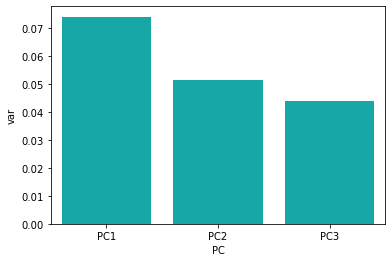

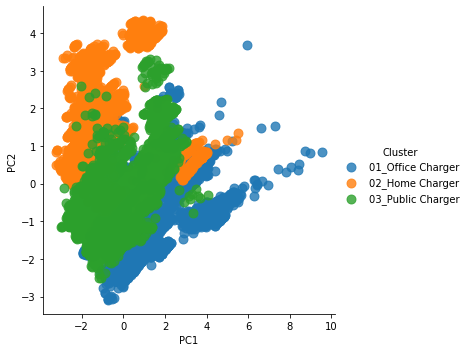

In [8]:
# PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn import decomposition

X1=X_scaled
Y1=X['Laadpaaltype']

pca = decomposition.PCA(n_components=3)
pc = pca.fit_transform(X1)
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1','PC2','PC3'])
pc_df['Cluster'] = Y1.tolist()
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80},# specify the point size
  x_ci='sd'      
          ) 
comps=pca.components_[0]

In [9]:
# linear regression

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_kost, test_size=0.33, random_state=42)

clf_lin = linear_model.LinearRegression()
clf_lin=clf_lin.fit(X_train, y_train)

y_lin_test=clf_lin.predict(X_test)
y_lin_train=clf_lin.predict(X_train)

print('mean_absolute_error lin test:' + str(mean_absolute_error (y_lin_test,y_test)))
print('mean_absolute_error lin train:' + str(mean_absolute_error (y_lin_train,y_train)))

mean_absolute_error lin test:0.029954729845059994
mean_absolute_error lin train:0.029675802479634264


In [10]:
# prints the values and magnitudes of the linear regression model coefficients for each feature, sorted


import numpy as np
coeffs_lin = clf_lin.coef_
comps=coeffs_lin
abs_comp =  np.array([abs(el) for el in comps])
inds=abs_comp.argsort()
vals=[comps[i] for i in inds]
features=[selection[i] for i in inds]
for i in range(len(features)):
    featr=features[i]
    if isinstance(featr, int):
        if featr<=9:
            features[i]=offices[featr]
        elif featr<=29:
            features[i]=car_types[featr-10]
        elif featr<=36:
            features[i]=weekdays[featr-30]
        else:
            features[i]=laadpaaltypes[featr-37]
print(vals)        
print(features)

[-0.0011965337747581377, -0.001519561139252696, -0.002610759372622623, -0.004554329867112027, -0.006974196147848776, -0.042119593322769266, -0.06761683096985632, -880216.1973152161, -238379564.6470978, -1106173751.6652243, -1151744226.0949764, -1244714619.3071911, -1270982237.2980611, -1280753136.1274102, -1283789731.8911242, -1286560056.0860608, -1299487406.7640588, -1453730731.1977472, -1613852004.8584385, -1805184445.3171937, -1940681072.370529, -1947154596.840063, -1969605359.573339, -2108791860.7933333, -2572678553.6962566, -2691817096.1849504, -3422511365.3626485, -3556094895.146221, -4200888525.1086717, -4207943007.318065, -4295256533.048983, -4329295021.599535, -4700088322.432562, -4975381331.562353, -5207636099.219081, -5833742193.875292, -6007785832.057957, -6086118673.321343, -6216107966.635992, -6417265687.859477, -6773322661.29612, -7298624121.762105, -8423741560.263844, -8766277040.59555, -12409090992.2235, -14328058342.48811]
['Year', 'Duration in minutes', 'Driver has h